In [1]:
!pip install -q transformers datasets librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
BASE_MODEL=	'ShakurovR/knv_model_v2' #'deepvk/USER-bge-m3' #"ai-forever/ruBert-base"
EMBEDDING_DIM = 1024

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [6]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "./content/new_train.csv", "validation": "./content/valid.csv"})
# data = load_dataset("csv", data_files={"train": "new_train.csv", "validation": "valid.csv"})

data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 51464
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [7]:
missing_text_train = [sample for sample in data["train"] if sample["text"] is None or sample["text"].strip() == ""]
print(f"Number of samples with missing or empty text in train: {len(missing_text_train)}")

missing_text_valid = [sample for sample in data["validation"] if sample["text"] is None or sample["text"].strip() == ""]
print(f"Number of samples with missing or empty text in validation: {len(missing_text_valid)}")


Number of samples with missing or empty text in train: 3
Number of samples with missing or empty text in validation: 0


In [8]:
# Вывод записей с пустым или отсутствующим текстом
print("Samples with missing or empty text in train:")
for sample in missing_text_train:
    print(sample)


Samples with missing or empty text in train:
{'text': None, 'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'neutral': 1}
{'text': None, 'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'neutral': 1}
{'text': None, 'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'neutral': 1}


In [9]:
# Удаление записей с пустым или отсутствующим текстом
data["train"] = [sample for sample in data["train"] if sample["text"] is not None and sample["text"].strip() != ""]


In [11]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'m', 'Л', 'w', 'ч', 'Ф', 'Б', 'l', 'B', 'S', 'x', 'н', '9', 'q', 'р', 'т', 'D', 'y', 'Е', 'о', 'К', 'а', '3', '_', 'ш', 'N', 'в', 'a', '.', 'Т', 'П', 'О', 'n', 'j', 'й', '?', 'м', 'ё', 'ю', 'C', 'I', '4', 'Д', 'Ж', 'Э', 'f', 'д', 'o', 'з', 'У', 'Г', 'Ч', 'd', '"', 't', 'п', 'Н', 'М', 'З', 'G', 'и', 'e', 'С', 'И', '1', 'T', ' ', '8', '2', 'ъ', 'б', '0', 'у', 'с', 'P', 'Я', 'Ю', 'ы', 'k', 'c', 'ж', 'х', 'к', 'Р', 'ц', 'v', 'Y', 'p', 'M', 'г', 'g', 'r', 'Х', 'Ш', 'л', 'u', 'я', 'е', 'b', 's', '5', 'ф', '-', ',', 'H', '6', 'А', 'A', ':', '7', 'i', 'W', 'э', 'щ', 'В', 'E', 'ь', '/', 'z', 'V', 'h', 'L'}
Valid unique symbols:  {'m', '&', 'Л', '🏻', 'w', 'ч', 'Ф', '=', '️', '😞', '🇦', '🖥', 'Б', '–', '😊', 'l', 'B', '🤗', '😩', '♀', '<', 'S', 'x', 'н', '9', '👏', 'ツ', 'q', 'р', 'т', '☹', 'D', '#', '\u200b', 'y', 'Е', 'о', 'К', 'а', '3', '_', '🤮', 'ш', '🍩', 'N', 'в', 'X', '☠', '🙃', 'Q', '.', 'a', 'Т', 'П', 'О', '“', 'n', '💍', '💖', 'j', '[', '\u200d', 'й', '😍', '?', '😂', 'м', 'ё

#### 📊 Построим гистограммы распределения

In [12]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

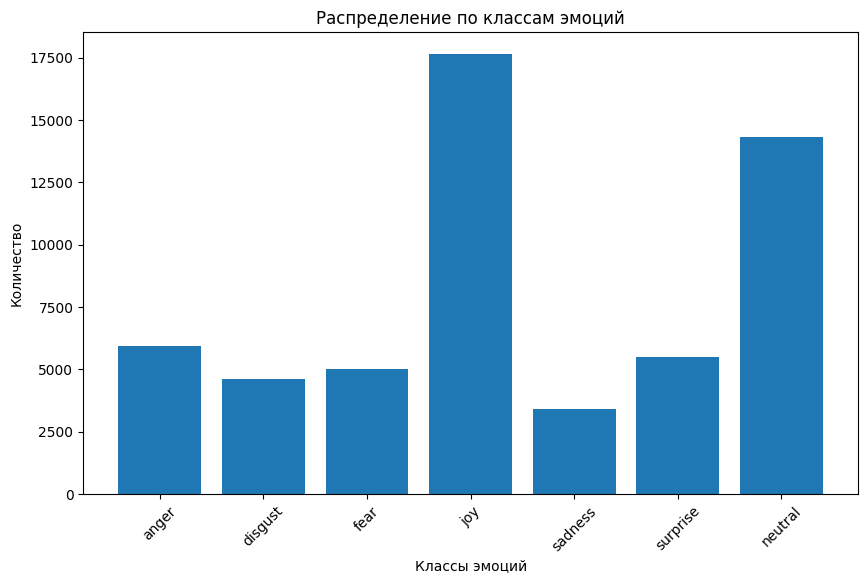

In [13]:
plot_histogram(data["train"])

In [14]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

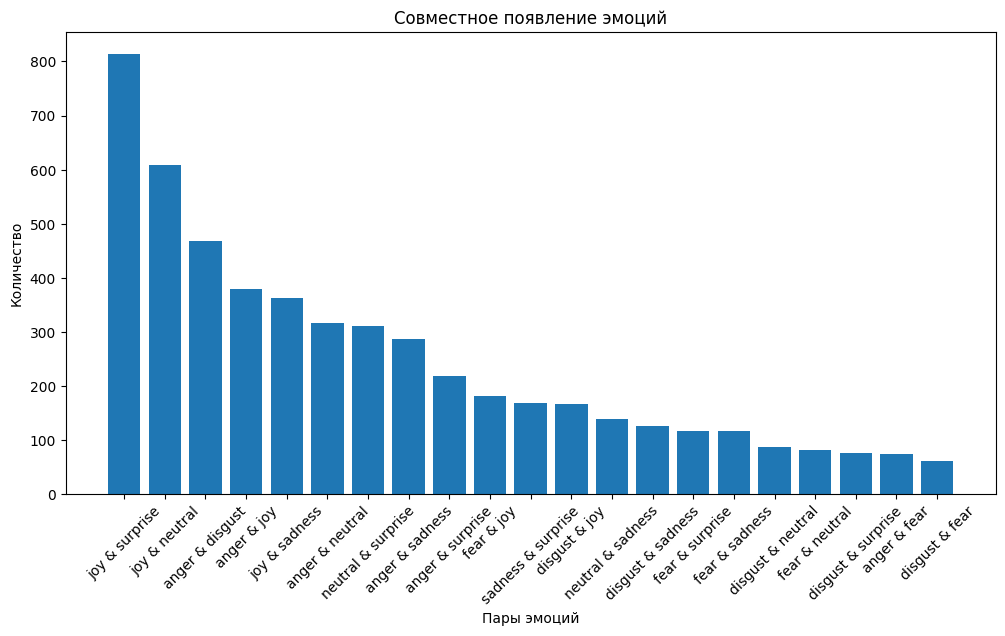

In [15]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [16]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

In [17]:
# Проверим типы данных
print(f"Тип data: {type(data)}")
print(f"Тип data['train']: {type(data['train'])}")
print(f"Тип data['validation']: {type(data['validation'])}")


Тип data: <class 'datasets.dataset_dict.DatasetDict'>
Тип data['train']: <class 'list'>
Тип data['validation']: <class 'datasets.arrow_dataset.Dataset'>


In [18]:
from datasets import Dataset

# Преобразуем data["train"] обратно в Dataset
data["train"] = Dataset.from_pandas(pd.DataFrame(data["train"]))

# Теперь data["train"] и data["validation"] имеют правильный тип
print(f"Тип data['train']: {type(data['train'])}")
print(f"Тип data['validation']: {type(data['validation'])}")

# Применяем функцию cleaner
data = data.map(cleaner)


Тип data['train']: <class 'datasets.arrow_dataset.Dataset'>
Тип data['validation']: <class 'datasets.arrow_dataset.Dataset'>


Map:   0%|          | 0/51461 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [45]:
data = data.map(cleaner)

Map:   0%|          | 0/51461 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [19]:
data["train"][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

#### 🏋️ Подготовим модель

In [20]:
class Model(torch.nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.hid = torch.nn.Linear(hidden_dim, 368)
        self.fc = torch.nn.Linear(368, num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.hid(features)
        output = self.fc(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model=BASE_MODEL, hidden_dim=EMBEDDING_DIM, num_classes=len(labels))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

#### 📒 Подготовим данные для обучения

In [21]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
max_len = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           return_token_type_ids=True,
                                           padding="max_length"), batched=True)

tokenizer_config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.49M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

Map:   0%|          | 0/51461 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [49]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

Map:   0%|          | 0/51461 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

[0, 0, 0, 0, 0, 0, 1]

#### 🔗 Dataset & DataLoader

In [51]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(self.dataset[index]["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [52]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [54]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001, weight_decay=0.)

#### 🥷 Код для обучения и валидации

In [55]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

    return model

In [56]:
data['train']

Dataset({
    features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral', 'input_ids', 'token_type_ids', 'attention_mask', 'one_hot_labels'],
    num_rows: 51461
})

In [57]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [60]:
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

Epoch: 0
Train loss: 0.26645002555773123
Valid loss: 0.2367856378064436
Epoch: 1
Train loss: 0.20679183291352313
Valid loss: 0.22825243104906642
Epoch: 2
Train loss: 0.18076358328324668
Valid loss: 0.2470497629221748


In [61]:
outputs, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs) >= 0.5
print(metrics.classification_report(targets, outputs, target_names=labels,digits=4))

Valid loss: 0.2470497629221748
              precision    recall  f1-score   support

       anger     0.5825    0.4630    0.5159       717
     disgust     0.3087    0.4742    0.3740        97
        fear     0.4661    0.5238    0.4933       105
         joy     0.7921    0.8292    0.8102      2219
     sadness     0.6250    0.5897    0.6069       390
    surprise     0.5647    0.4407    0.4950       624
     neutral     0.7317    0.4417    0.5508      1766

   micro avg     0.7003    0.6012    0.6470      5918
   macro avg     0.5815    0.5375    0.5495      5918
weighted avg     0.7000    0.6012    0.6378      5918
 samples avg     0.6364    0.6194    0.6211      5918



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# outputs, targets = validation(model, criterion, valid_dataloader)
# outputs = np.array(outputs) >= 0.5
# print(metrics.classification_report(targets, outputs, target_names=labels,digits=4))

Valid loss: 0.22789398203877842
              precision    recall  f1-score   support

       anger     0.6494    0.4031    0.4974       717
     disgust     0.5510    0.2784    0.3699        97
        fear     0.7308    0.3619    0.4841       105
         joy     0.8152    0.8112    0.8132      2219
     sadness     0.7263    0.5308    0.6133       390
    surprise     0.5696    0.4984    0.5316       624
     neutral     0.6910    0.5674    0.6231      1766

   micro avg     0.7297    0.6208    0.6709      5918
   macro avg     0.6762    0.4930    0.5618      5918
weighted avg     0.7205    0.6208    0.6623      5918
 samples avg     0.6610    0.6414    0.6442      5918



c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ✏️ Получаем результаты на тесте

In [ ]:
test = load_dataset("csv", data_files={"test": "./content/test_without_answers.csv"})

In [ ]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           return_token_type_ids=True,
                                           padding="max_length"), batched=True)

test = test.map(one_hot_to_list)

In [ ]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= 0.5

Valid loss: 0.30976709246199075


#### 🧑‍🍳 Готовим сабмит

In [ ]:
import pandas as pd

df = pd.read_csv("./content/test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [ ]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,0,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,0,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,0,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,0


In [ ]:
df.insert(loc=0, column='id', value=np.arange(1, len(df) + 1))
df = df.drop(['text'],axis=1)

In [ ]:
df[labels] = outputs.astype(int)

In [ ]:
df.head()

,id,anger,disgust,fear,joy,sadness,surprise,neutral
0,1,0,0,0,1,0,0,0
1,2,0,0,0,1,0,0,0
2,3,0,0,0,0,0,0,0
3,4,0,0,0,0,1,1,0
4,5,0,0,0,0,0,0,1


In [ ]:
df.to_csv("./content/submission_v4.csv", index=False)

: 